# 傾向スコアを用いた TV CM の視聴によるゲーム利用傾向の変化の分析

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%config InlineBackend.figure_format = 'retina'

In [13]:
%load_ext autoreload
%autoreload 2

from pycalf import metrics
from pycalf import visualize
from pycalf import propensity
from pycalf.uplift import UpliftModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Download from https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv
df = pd.read_csv('sample/q_data_x.csv')

In [15]:
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


傾向スコアを求めるために、共変量・結果変数・介入変数を定義します。

In [41]:
# Define variables required for inference.
covariate_cols = [
    'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney',
    'area_kanto', 'area_tokai', 'area_keihanshin', 'job_dummy1', 'job_dummy2',
    'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
    'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'
]
outcome_cols = ['gamecount', 'gamedummy', 'gamesecond']
treatment_col = 'cm_dummy'

傾向スコアを求めるモデルにはロジスティック回帰を用いるので、共変量をスケーリングします。

そして、IPWを用いたモデルを定義します。

In [42]:
# Set Values from dataframe.
X = df[covariate_cols]
y = df[outcome_cols]
treatment = df[treatment_col].astype(bool).to_numpy()

# Scaling Raw Data.
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Define IPW Class.
learner = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
model = propensity.IPW(learner)

# Fit model.
model.fit(scaled_X, treatment)

## IPW

### 効果量dを用いた共変量の調整の様子を確認

IPW によって、共変量のばらつきが調整されたのかを効果量dを用いて確認する。

In [43]:
ate_weight = model.get_weight(treatment, mode='ate')
es = metrics.EffectSize()
es.fit(X, treatment, weight=ate_weight)
es.transform()

(array(['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc',
        'pmoney', 'area_kanto', 'area_tokai', 'area_keihanshin',
        'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4',
        'job_dummy5', 'job_dummy6', 'job_dummy7', 'fam_str_dummy1',
        'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'], dtype=object),
 array([0.13846538, 0.07087411, 0.04615925, 0.02934219, 0.0119451 ,
        0.07186398, 0.00322885, 0.02722615, 0.14518075, 0.01426944,
        0.08135214, 0.03176526, 0.00282704, 0.01120574, 0.05837685,
        0.00744712, 0.0505439 , 0.06158705, 0.01347874, 0.06350157,
        0.00177609]))

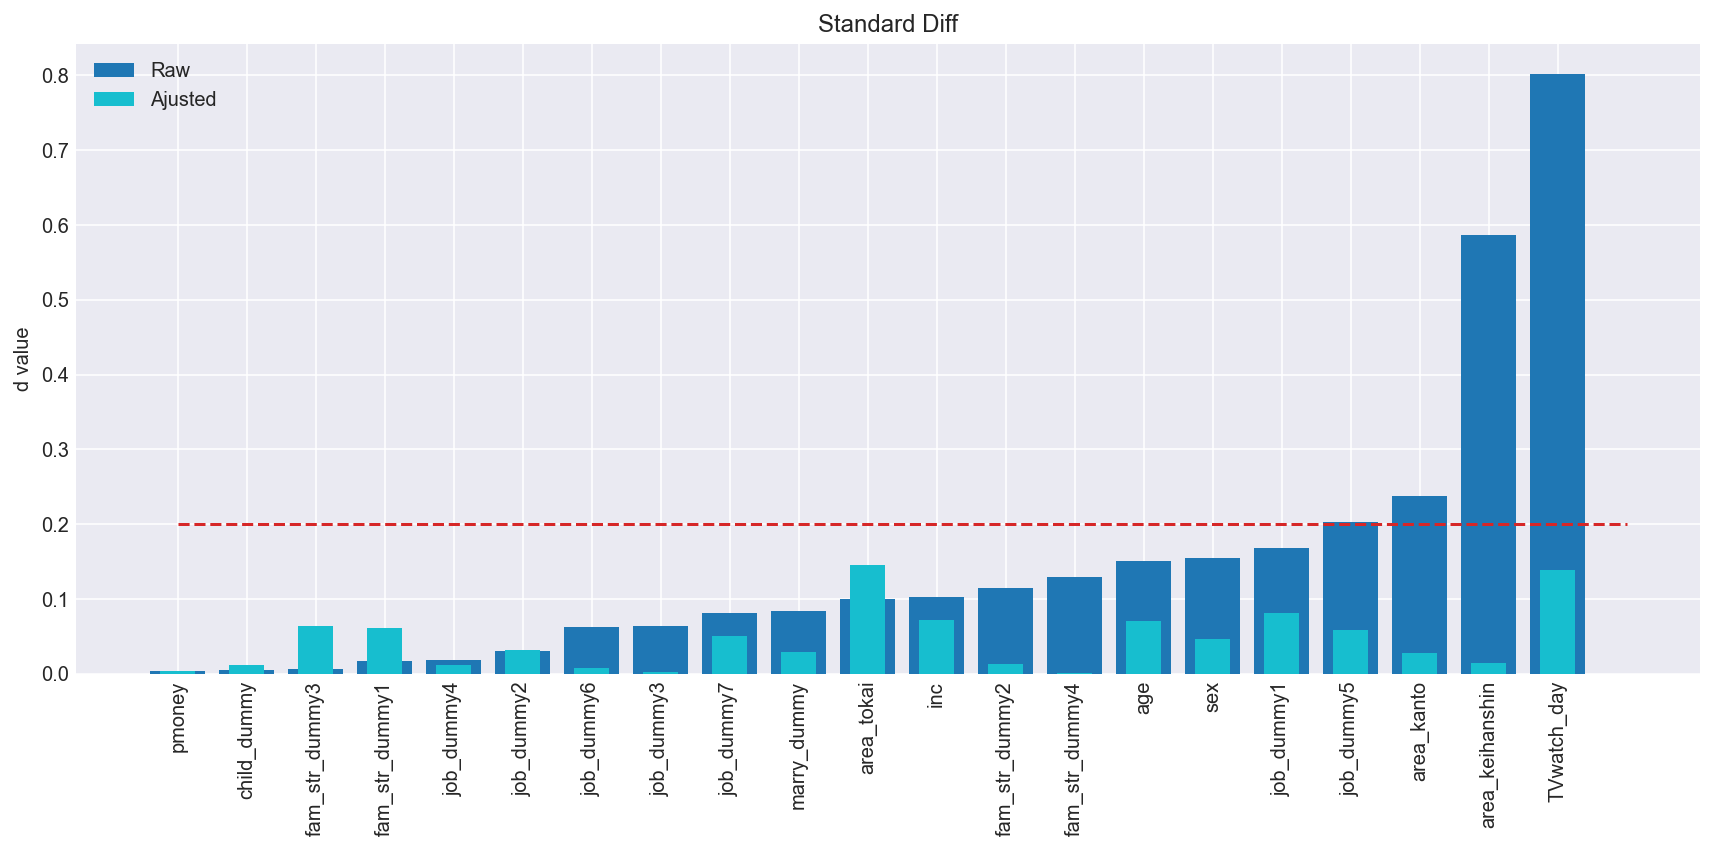

In [44]:
visualize.plot_effect_size(X, treatment, weight=ate_weight, ascending=True)

In [45]:
outcome = model.estimate_effect(treatment, y.to_numpy(), mode='ate')
pd.DataFrame(outcome, index=['Z0', 'Z1', 'ATE'], columns=y.columns.tolist()).T

,Z0,Z1,ATE
gamecount,8.488374,13.121695,4.633321
gamedummy,0.063544,0.093011,0.029466
gamesecond,2691.407119,3959.155313,1267.748194


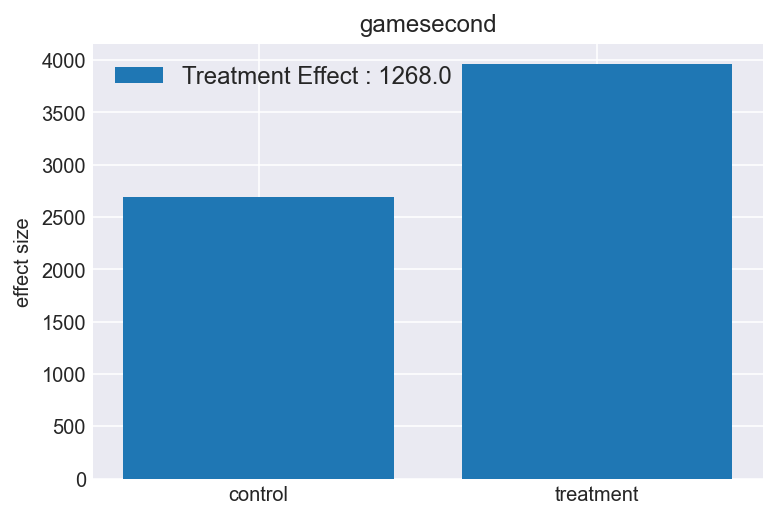

In [46]:
outcome_name = 'gamesecond'
z0, z1, treat_effect = model.estimate_effect(treatment, y[outcome_name].to_numpy(), mode='ate')
visualize.plot_treatment_effect(outcome_name, z0, z1, treat_effect.round())

## Uplift Modeling

In [47]:
import copy
from sklearn.model_selection import train_test_split

In [52]:
# Define variables required for inference.
covariate_cols = [
    'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney',
    'area_kanto', 'area_tokai', 'area_keihanshin', 'job_dummy1', 'job_dummy2',
    'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
    'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'
]
outcome_cols = 'gamedummy'
treatment_col = 'cm_dummy'

# Set Values from dataframe.
scaler = preprocessing.MinMaxScaler()
df[covariate_cols] = scaler.fit_transform(df[covariate_cols].to_numpy())

X = df[covariate_cols]
treatment = df[treatment_col].astype(bool)
y = df[outcome_cols].astype(bool)
weight = model.get_weight(treatment, mode='ate')


X_train, X_test, z_train, z_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, treatment, y, weight, test_size=0.5, random_state=42)

In [54]:
X_treat, y_treat = X_train[z_train == 1], y_train[z_train == 1]
X_control, y_control = X_train[z_train == 0], y_train[z_train == 0]
weight_treat, weight_control = weight_train[z_train == 1], weight_train[z_train == 0]



learner = LogisticRegression(solver='lbfgs', C=0.1, max_iter=100, random_state=42)
learner_treat = copy.deepcopy(learner)
learner_control = copy.deepcopy(learner)
model = UpliftModel(learner_treat, learner_control)
model.fit(X_treat, y_treat, X_control, y_control, weight_treat, weight_control)

uplift_score, lift = model.predict(X_test, z_test.to_numpy(), y_test.to_numpy())

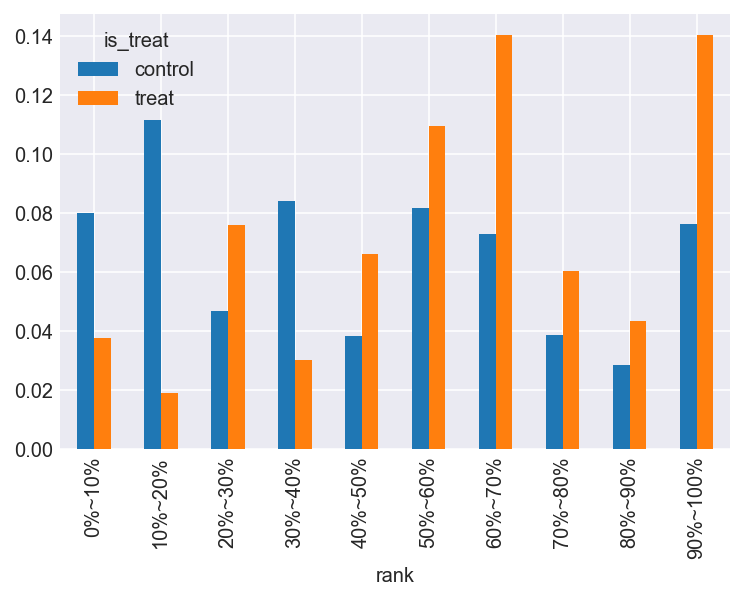

In [55]:
uplift_score = model.estimate_uplift_score(X_test)
result = list(zip(y_test, z_test, uplift_score))
result.sort(key=lambda x: x[2], reverse=True)

qdf = pd.DataFrame(result, columns=('cv', 'is_treat', 'uplift_sore'))
qdf['rank'] = pd.qcut(qdf['uplift_sore'], 10, labels=["{}%~{}%".format(n*10, (n+1)*10) for n in range(10)])
qdf['is_treat'] = qdf['is_treat'].map({False: 'control', True: 'treat'})

pivot_qdf = qdf.pivot_table(index='rank', columns='is_treat', values='cv', aggfunc=np.mean)
pivot_qdf.plot(kind='bar')

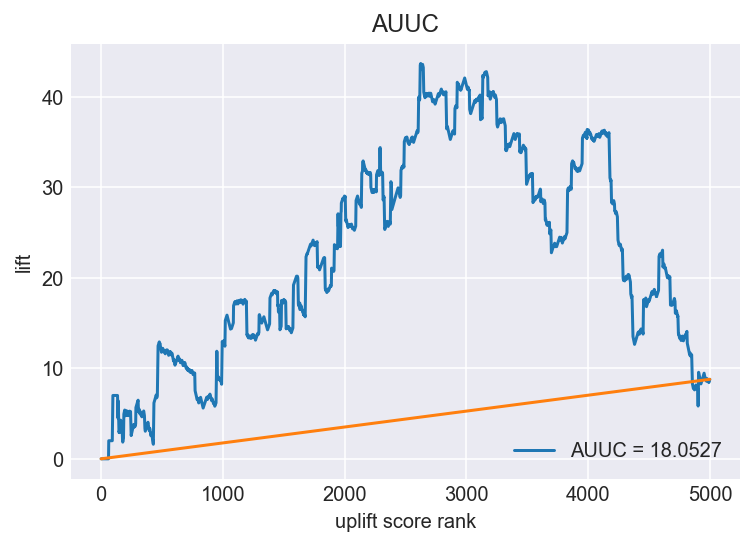

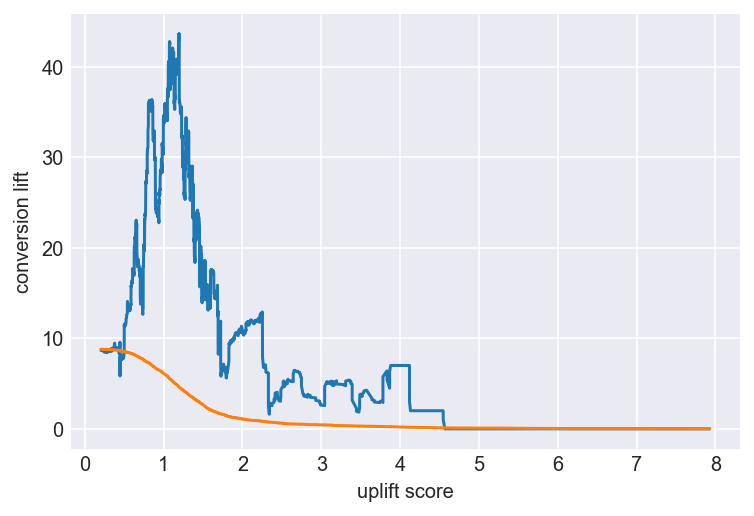

In [56]:
auuc_score = model.get_auuc(lift)
base_line = model.get_baseline(lift)
visualize.plot_auuc(uplift_score, lift, base_line, auuc_score)

uplift_score, lift = model.predict(X_test, z_test.to_numpy(), y_test.to_numpy())
base_line = model.get_baseline(lift)

plt.plot(uplift_score, lift)
plt.plot(uplift_score, base_line)
plt.xlabel("uplift score")
plt.ylabel("conversion lift")
plt.show()